https://www.ethnologue.com/

# Parsing Code

In [ ]:
import requests
from lxml import html
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import time
import json
import re

# Gets the name of every language and their links
def parse_languages(url):
    response = requests.get(url)
    tree = html.fromstring(response.content)

    # XPath to find all <p> tags with class containing `lang--` and extract the text within the nested <a> tags
    languages = tree.xpath('//p[contains(@class, "lang--")]/a/text()')
    languages = [lang.strip() for lang in languages if lang.strip()]

    # XPath to find the link for each language
    language_links = tree.xpath('//p[contains(@class, "lang--")]/a/@href')
    base_url = "https://www.ethnologue.com"  # Base URL of the website
    full_language_links = [urljoin(base_url, link) for link in language_links]

    return languages, full_language_links

# Ensures every page is parsed so no language is missed
def find_links_to_other_pages(url):
    response = requests.get(url)
    tree = html.fromstring(response.content)

    # XPath to find all <button> elements for different alphabet letters
    links = tree.xpath('//button[@class="tab__link"]/@onclick')
    # Extract the URL part from the onclick attribute
    links = [link.split('"')[1] for link in links if 'browse' in link]
    # Convert to full URLs
    full_links = [urljoin(url, f'/browse/names/{link}') for link in links]

    return full_links

def main(start_url):
    visited = set()
    to_visit = [start_url]
    all_languages = []
    all_full_language_links = []  # Store all full language links

    while to_visit:
        current_url = to_visit.pop()
        if current_url in visited:
            continue

        visited.add(current_url)
        languages, full_language_links = parse_languages(current_url)
        all_languages.extend(languages)
        all_full_language_links.extend(full_language_links)  # Store full language links

        links = find_links_to_other_pages(current_url)
        to_visit.extend(links)

    return all_languages, all_full_language_links

start_url = 'https://www.ethnologue.com/browse/names/'
languages, full_language_links = main(start_url)

language_names = languages
language_urls = full_language_links



In [ ]:
# Function to scrape information from individual language pages
def scrape_language_info(language_url):
    try:
        # Send a GET request to the language page
        response = requests.get(language_url)
        response.raise_for_status()  # Raise an HTTPError for bad responses

        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        data = {}

        # Extracting coordinates from JavaScript variable in HTML
        coordinates_script = soup.find('script', string=re.compile(r'geometry:\{type:"Point",coordinates:\["-?\d+\.\d+","-?\d+\.\d+"\]\}'))
        if coordinates_script:
            coordinates_match = re.search(r'geometry:\{type:"Point",coordinates:\["(-?\d+\.\d+)","(-?\d+\.\d+)"\]\}', coordinates_script.string)
            if coordinates_match:
                data['coordinates'] = {
                    "latitude": coordinates_match.group(1),
                    "longitude": coordinates_match.group(2)
                }
            else:
                data['coordinates'] = 'N/A'
        else:
            data['coordinates'] = 'N/A'


        # Extract ISO 639 code
        iso_code_element = soup.find('a', class_='chip chip--big')
        if iso_code_element:
            data['iso_code'] = iso_code_element.text.strip()

        # Extract population info
        population_element = soup.find('li', class_='population__sizes')
        if population_element:
            population_div = population_element.find('div', class_='graph__langpop')
            if population_div:
                data['population'] = population_div.text.strip()

        # Extract language status (vitality)
        vitality_element = soup.find('li', class_='population__vitality')
        data['language_status'] = 'Unknown'  # Default value
        if vitality_element:
            vitality_status = vitality_element.find_all('li', class_='histogram__datum')
            for status in vitality_status:
                if 'data-count' in status.attrs and status['data-count'].isdigit() and int(status['data-count']) > 0:
                    label = status.find('label')
                    if label:
                        data['language_status'] = label.text.strip()
                        break

        # Extract language family
        family_element = soup.find('h2', {'id': 'tyopologyHeading'})
        if family_element:
            family_paragraph = family_element.find_next('p', class_='typology well section__list')
            if family_paragraph:
                family_link = family_paragraph.find('a')
                if family_link:
                    data['family'] = family_link.text.strip()
                else:
                    data['family'] = 'N/A'
            else:
                data['family'] = 'N/A'
        else:
            data['family'] = 'N/A'

        return data

    except requests.RequestException as e:
        print(f"Request failed for URL {language_url}: {e}")
        return {}

# Introduce a delay of 3 seconds between each request
delay_between_requests = 3

# Combine language names and URLs into pairs
language_info_pairs = zip(language_names, language_urls)

# Dictionary to store language information
language_info_dict = {}

# Iterate over each language URL and scrape information
for language_name, language_url in language_info_pairs:
    language_info = scrape_language_info(language_url)
    language_info_dict[language_name] = {
        "iso_code": language_info.get('iso_code', 'N/A'),
        "coordinates": language_info.get('coordinates', 'N/A'),
        "population": language_info.get('population', 'N/A'),
        "language_status": language_info.get('language_status', 'N/A'),
        "family": language_info.get('family', 'N/A')
    }
    time.sleep(delay_between_requests)



In [ ]:
# Convert the dictionary to JSON with proper Unicode characters
json_data = json.dumps(language_info_dict, indent=4, ensure_ascii=False)

# Specify the file name
file_name = "language_info.json"

# Write JSON data to a file
with open(file_name, "w", encoding="utf-8") as json_file:
    json_file.write(json_data)

# Print the name of the created file
print(f"JSON data has been saved to '{file_name}'.")

JSON data has been saved to 'language_info.json'.


In [ ]:
# Paths to the JSON files
json_file_1 = "/content/language_info1.json"
json_file_2 = "/content/language_info2.json"

# Load the JSON data from both files
with open(json_file_1, 'r') as f1, open(json_file_2, 'r') as f2:
    data1 = json.load(f1)
    data2 = json.load(f2)

# Combine the dictionaries (data2 into data1)
combined_data = {**data1, **data2}

# Convert the combined dictionary to a JSON string
json_data = json.dumps(combined_data, indent=4, ensure_ascii=False)

file_name = "language_info.json"

# Write JSON data to a file
with open(file_name, "w", encoding="utf-8") as json_file:
    json_file.write(json_data)

# Print the name of the created file
print(f"JSON data has been saved to '{file_name}'.")

JSON data has been saved to 'language_info.json'.


In [ ]:
# Use this to change the population of the Endangered and Extinct languages with 'none' to '0'
# This is optional :)

import json

# Load your JSON data
with open('language_info.json', 'r', encoding='utf-8') as f:
    language_data = json.load(f)

# Define a function to convert 'None' to 0 for extinct and endangered languages
def convert_population_none_to_zero(language_data):
    for lang, info in language_data.items():
        if info['language_status'] == 'Extinct' or info['language_status'] == 'Endangered':
            if info['population'].strip().lower() == 'none':
                info['population'] = '0'

# Convert 'None' populations to '0' for Extinct and Endangered languages
convert_population_none_to_zero(language_data)

# Save the modified data back to the JSON file
with open('language_info.json', 'w', encoding='utf-8') as f:
    json.dump(language_data, f, indent=4)

print('Population conversion completed and saved to language_info_modified.json')


# Language Diversity

Prepares data for a pie chart visualization and plots the pie chart using Matplotlib. It provides a clear visual representation of the distribution of language statuses based on the data.

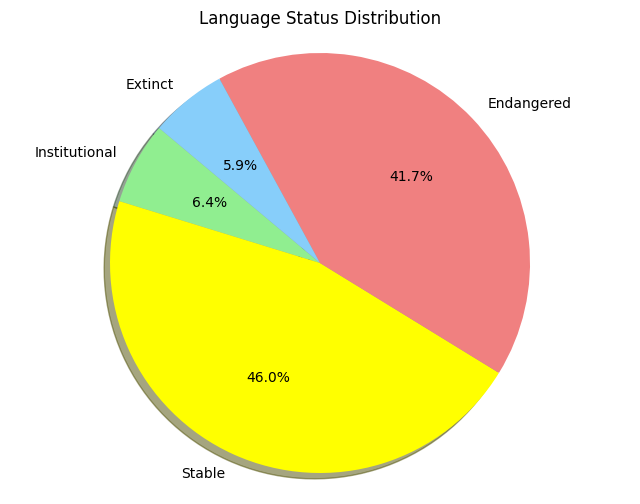

In [ ]:
import json
import matplotlib.pyplot as plt

# Load your JSON data
with open('language_info.json', 'r', encoding='utf-8') as f:
    language_data = json.load(f)

# Count the number of languages in each status category
status_counts = {
    'Institutional': 0,
    'Stable': 0,
    'Endangered': 0,
    'Extinct': 0
}

for info in language_data.values():
    status = info.get('language_status', None)
    #if status == 'Institutional' or status == 'Stable':
        #status = 'Alive'  # Count Institutional and Stable as Alive
    if status in status_counts:
        status_counts[status] += 1

# Prepare data for the pie chart
labels = list(status_counts.keys())
sizes = list(status_counts.values())
colors = ['lightgreen', 'yellow', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0,0)

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Language Status Distribution')
plt.show()


This code categorizes languages by their family and status ('Institutional', 'Stable', 'Endangered', 'Extinct'), combining 'Institutional' and 'Stable' statuses into an 'Alive' category. The script counts the number of languages in each family under each status category and makes a stacked bar chart. Each bar in the chart represents the count of languages categorized as 'Alive', 'Endangered', and 'Extinct' within their respective language families and colors.

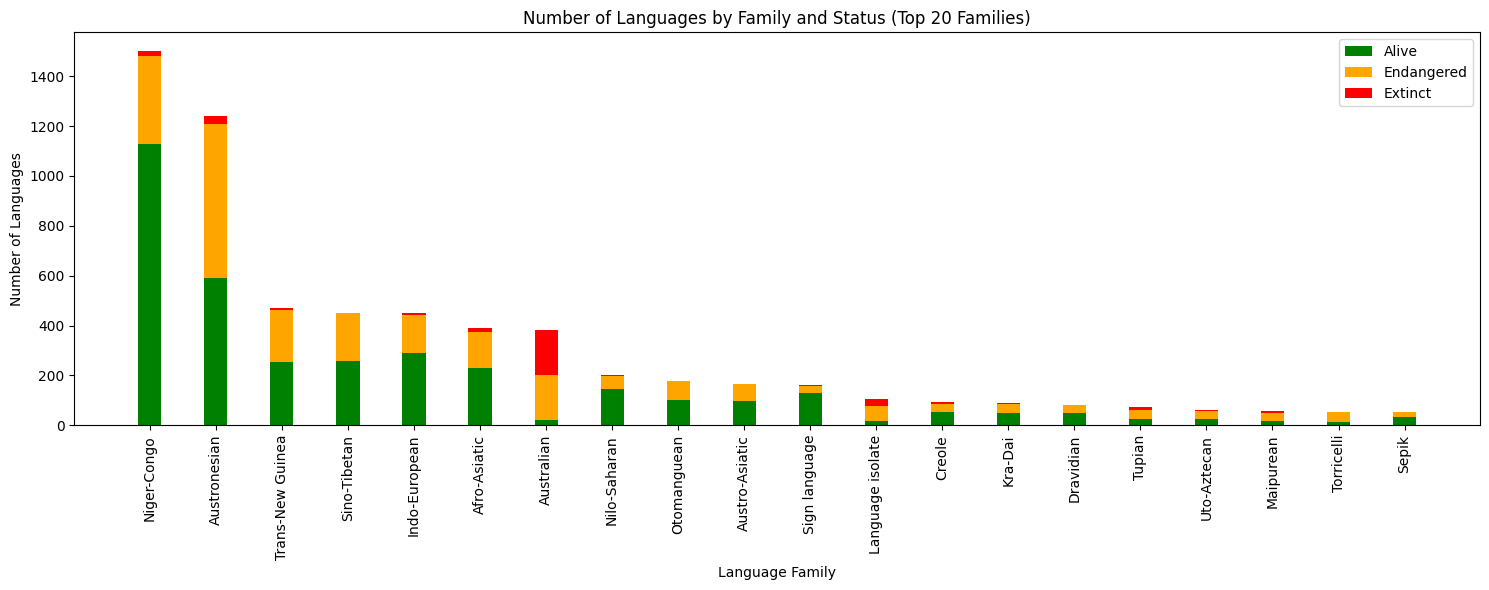

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load your JSON data
with open('language_info.json', 'r', encoding='utf-8') as f:
    language_data = json.load(f)

# Count languages in each family by status
family_status_counts = {}
status_colors = {'Institutional': 'green', 'Stable': 'green', 'Endangered': 'orange', 'Extinct': 'red'}

for info in language_data.values():
    family = info.get('family', 'Unknown')
    lang_status = info.get('language_status', None)
    if lang_status in status_colors:
        if family not in family_status_counts:
            family_status_counts[family] = {'Alive': 0, 'Endangered': 0, 'Extinct': 0}

        # Combine both 'Institutional' and 'Stable' into 'Alive' count
        if lang_status == 'Institutional' or lang_status == 'Stable':
            family_status_counts[family]['Alive'] += 1
        elif lang_status == 'Endangered':
            family_status_counts[family]['Endangered'] += 1
        elif lang_status == 'Extinct':
            family_status_counts[family]['Extinct'] += 1

# Sort families by total language count (most popular first)
sorted_families = sorted(family_status_counts.items(), key=lambda x: sum(x[1].values()), reverse=True)

# Select top 25 families
top_families = sorted_families[:25]

# Prepare data for stacked bar chart
families = [family for family, _ in top_families]
alive_counts = [family_status_counts[family].get('Alive', 0) for family in families]
endangered_counts = [family_status_counts[family].get('Endangered', 0) for family in families]
extinct_counts = [family_status_counts[family].get('Extinct', 0) for family in families]

ind = np.arange(len(families))
width = 0.35

# Plotting the stacked bar chart
plt.figure(figsize=(15, 6))
p1 = plt.bar(ind, alive_counts, width, color='green')
p2 = plt.bar(ind, endangered_counts, width, bottom=alive_counts, color='orange')
p3 = plt.bar(ind, extinct_counts, width, bottom=np.array(alive_counts) + np.array(endangered_counts), color='red')

plt.xlabel('Language Family')
plt.ylabel('Number of Languages')
plt.title('Number of Languages by Family and Status (Top 25 Families)')
plt.xticks(ind, families, rotation=90)
plt.legend((p1[0], p2[0], p3[0]), ('Alive', 'Endangered', 'Extinct'))
plt.tight_layout()
plt.show()


This code visualizes the geospatial distribution of languages along with their status using Matplotlib. It loads data from a 'language_info.json'. It then extracts latitude and longitude coordinates for languages with valid status colors (defined as 'Institutional' in green, 'Stable' in blue, 'Endangered' in orange, and 'Extinct' in red). The languages are plotted on a scatter plot where each point is colored according to its status. This visualization provides insights into the global distribution of languages and their current statuses.

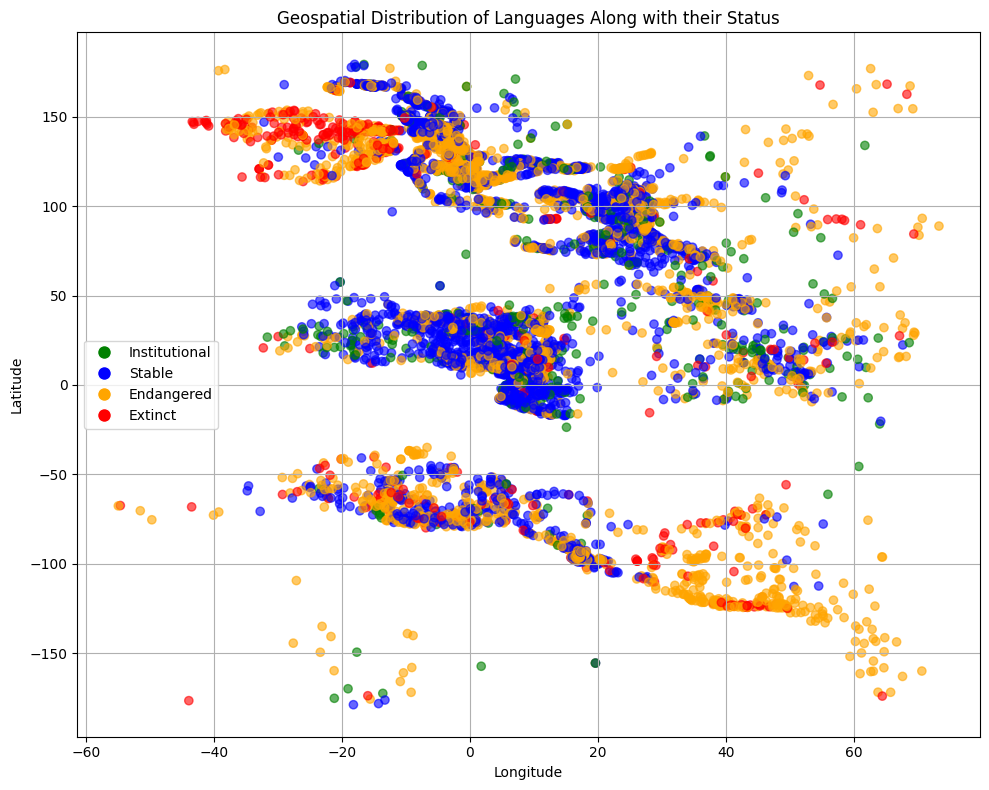

In [ ]:
import json
import matplotlib.pyplot as plt

# Load your JSON data
with open('language_info.json', 'r', encoding='utf-8') as f:
    language_data = json.load(f)

# Prepare data for geospatial plot
lats = []
lons = []
colors = []
status_colors = {'Institutional': 'green', 'Stable': 'blue', 'Endangered': 'orange', 'Extinct': 'red'}

for lang, info in language_data.items():
    coords = info.get('coordinates', None)
    lang_status = info.get('language_status', None)
    if coords and lang_status in status_colors:
        lats.append(float(coords.get('latitude', 0)))
        lons.append(float(coords.get('longitude', 0)))
        colors.append(status_colors[lang_status])

# Plotting the geospatial plot with color-coded statuses
plt.figure(figsize=(10, 8))
plt.scatter(lons, lats, color=colors, alpha=0.6)

# Adding legend
legend_labels = ['Institutional', 'Stable', 'Endangered', 'Extinct']
legend_colors = ['green', 'blue', 'orange', 'red']
legend_handles = [plt.Line2D([0, 1], [0, 0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
plt.legend(legend_handles, legend_labels, loc='best')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Distribution of Languages Along with their Status')
plt.grid(True)
plt.tight_layout()
plt.show()


This code counts the occurrences of each language family and sorts them in descending order based on their frequency. The top 11 most popular language families are selected and displayed in a pie chart, while all other families are aggregated into an 'Other' category. The pie chart visualizes the distribution of languages across these top families, with each segment representing the proportion of languages within that family compared to the total. The chart includes percentage labels and a title to provide a clear overview of the most prevalent language families in the dataset.

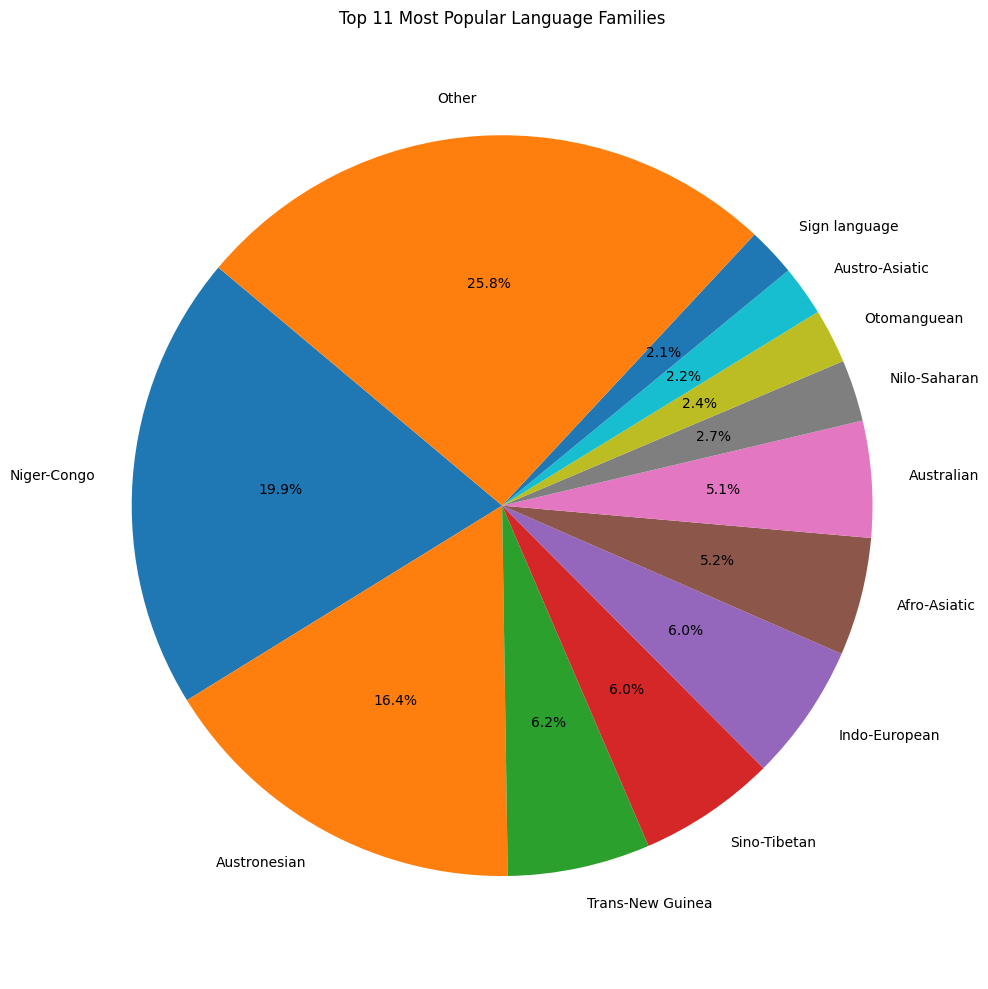

In [ ]:
import json
import matplotlib.pyplot as plt

# Load your JSON data
with open('language_info.json', 'r', encoding='utf-8') as f:
    language_data = json.load(f)

# Count languages in each family
family_counts = {}
for info in language_data.values():
    family = info.get('family', 'Unknown')
    if family in family_counts:
        family_counts[family] += 1
    else:
        family_counts[family] = 1

# Sort families by count (most popular first)
sorted_families = sorted(family_counts.items(), key=lambda x: x[1], reverse=True)

# Extract top 15 families and their counts
top_12_families = sorted_families[:11]
other_count = sum(count for family, count in sorted_families[11:])

# Prepare data for pie chart
labels = [family[0] for family in top_12_families]
sizes = [family[1] for family in top_12_families]
labels.append('Other')
sizes.append(other_count)

# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Top 11 Most Popular Language Families')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()
